# Data Preparation Tutorial

This tutorial include example code to prepare the data required to run IS-Count to estimate the building count in **New York State**, using nightlight (NL) as the proposal distribution.

In [10]:
import numpy as np
from matplotlib import cm, pyplot as plt
import pandas as pd
import os
import csv
import pyreadr

import torch

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon

import random
import sys
from tqdm import trange
from tqdm import tqdm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import rasterio as rs
from rasterio.plot import show
import rasterio

import rioxarray as rxr
import xarray as xr

from osgeo import gdal
import pyproj
from functools import partial
from pyproj import Proj, transform
from pyproj import CRS
from affine import Affine

from geomet import wkt
print(pyproj.__version__)

import pandas as pd
import warnings
warnings.simplefilter('ignore')

import geopy
import geopy.distance

from scipy import spatial
from osgeo import gdal
import numpy as np

sys.path.append('..')
from utils.utils import ray_tracing_numpy_numba, pixel_to_coord, load_geotiff, coord_to_pixel_loaded, create_data, compute_pixel_size, kd_tree_object_count
from utils.constants import GT_MS_COUNT, GT_OPEN_BUILDINGS_COUNT, US_STATES, AFRICAN_COUNTRIES

3.0.1


## Define util functions

In [11]:
def get_index(name_list, district):
    for i in range(len(name_list)):
        name = name_list[i].lower()
        name = name.replace(" ", "_")
        if name == district:
            return i
    print("district {} not found in the us states".format(district))
    exit()

## Set up necessary global values

In [12]:
sampling_method = 'NL'
country = 'us'
district = 'new_york'

## Create mask

The first step is to create the mask for the region of interest. In the following code, we show an example of New York State. For more efficient batch-wise mask creation (e.g. all states in the US), run the script `create_mask.py` by following the command lines in the file `data/README.md`.

In [7]:
NL_DATA = '../sample_data/covariates/NL_raster.tif'
POP_DATA = '../sample_data/covariates/population_raster.tif'

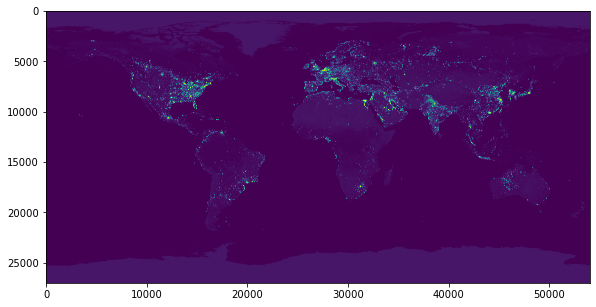

In [8]:
if sampling_method == 'NL':
    data_dir = NL_DATA
    channel = load_geotiff(data_dir)
elif sampling_method == 'population':
    data_dir = POP_DATA
    channel = load_geotiff(data_dir)

# Show the complete NL raster
plt.figure(figsize=(10,5))
plt.imshow(channel)

Note: We manually select the bounding box when creating the binary mask for the target region **only to save memory**. Theoretically, saving the binary mask directly from the complete NL raster does not have any impact on the algorithm.

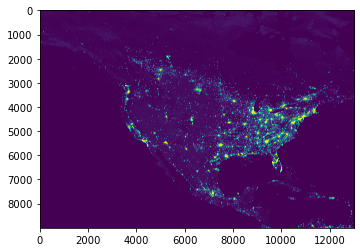

In [9]:
# Show the partial NL raster in the contiguous US
cutsizex = [3000, 12000]
cutsizey = [5000, 18000]

plt.imshow(channel[cutsizex[0]:cutsizex[1], cutsizey[0]:cutsizey[1]])

In [16]:
# Load the shapefile for the target region
shapefile = gpd.read_file('../sample_data/shapefiles/us_states/cb_2018_us_state_20m.shp')
index = get_index(shapefile['NAME'], district)
poly = shapefile['geometry'][index] # the polygon for NY

In [19]:
# Create binary mask for NY

channel = load_geotiff(data_dir)
covariate_data = rs.open(data_dir)
x_grid = np.meshgrid(np.arange(cutsizey[1] - cutsizey[0]), 
                     np.arange(cutsizex[1] - cutsizex[0]), 
                     sparse=False,
                     indexing='xy')
grid = np.array(np.stack([x_grid[1].reshape(-1), x_grid[0].reshape(-1)], axis=1))
cut = channel[cutsizex[0]:cutsizex[1], cutsizey[0]:cutsizey[1]]
probs = cut[grid[:, 0], grid[:, 1]] / cut.sum()
gt_data_coordinate = pixel_to_coord(grid[:, 0], 
                                    grid[:, 1], 
                                    cutsizex[0], 
                                    cutsizey[0], 
                                    covariate_data.transform)

In [20]:
points = gt_data_coordinate
print(len(points))
batch_size = 10000 # Batch size should divide number of points.

117000000


In [21]:
results_arr = []

# poly = [poly] # might need to comment out if ploy is an array
for t in tqdm(range(len(points) // batch_size)):
    results = np.zeros(len(points[t * batch_size:(t + 1) * batch_size]))
    if type(poly) == Polygon:
        temp_results = ray_tracing_numpy_numba(points[t * batch_size:(t + 1) * batch_size],
                                                   np.stack([poly.exterior.coords.xy[0], poly.exterior.coords.xy[1]],
                                                            axis=1))
        results += temp_results
    else:
        for i in (range(len(poly))):
            temp_results = ray_tracing_numpy_numba(points[t * batch_size:(t + 1) * batch_size], np.stack(
                    [poly[i].exterior.coords.xy[0], poly[i].exterior.coords.xy[1]], axis=1))
            results += temp_results

    results_arr.extend(results)

results_arr = (np.array(results_arr) != 0)

100%|██████████| 11700/11700 [03:01<00:00, 64.33it/s]


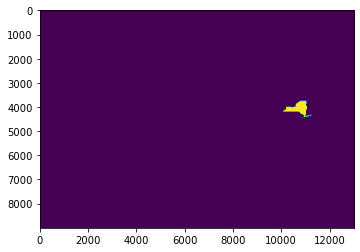

In [22]:
# Show the binary mask
binary_m = (results_arr).reshape(cutsizex[1]-cutsizex[0], cutsizey[1]-cutsizey[0])
plt.imshow(binary_m)

# Save the binary mask
torch.save(binary_m, f'../sample_data/{sampling_method}/{cutsizex[0]}_{cutsizex[1]}_{cutsizey[0]}_{cutsizey[1]}_{district}_mask.pth')

## Create data

Using the binary mask created in the previous step, we then move on to construct the base distribution using the covariates (e.g. NL or population). In the following code, we show the example of using NL to construct the proposal distribution. Specifically, we will cover the procedures for:
* Processing the raster covariate data into a discrete distribution
* Saving the data into the matching folder

In [67]:
# To collect the building count in every satellite image tile
# we use Microsoft Building Footprint data.
# The original data is in geojson format, and we saved it as pth files. 

shape_data = gpd.read_file(f"../sample_data/ms_building_footprint/{country}/{''.join([district.split('_')[i].capitalize() for i in range(len(district.split('_')))])}.geojson")
center_x = shape_data['geometry'].centroid.x # lon
center_y = shape_data['geometry'].centroid.y # lat
torch.save([center_x, center_y], f"../sample_data/ms_building_footprint/{district}_center.pth")

In [30]:
# Directly load the pth file if exists
[center_x, center_y] = torch.load(f"../sample_data/ms_building_footprint/{country}/{''.join(district.split('_'))}_center.pth")
center_x, center_y = np.array(center_x), np.array(center_y)

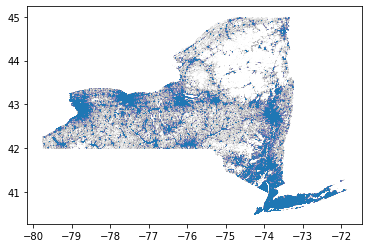

In [40]:
plt.scatter(center_x, center_y, s=0.00001, alpha=0.5)

### Train data
Used only in `isotonic_regression.py`. The positive examples are sampled from the building footprint datasets. The negative examples are sampled from the region uniformly. Both positive and negative sets are saved as pth files with building count labels.

In [50]:
# Set up arguments and load rasters
total_sample_size = 2000 # Modify this number to change the number of positive samples to collect
satellite_size = 640 * 0.0003 # Modify this number to change the area of each tile

raster_nl = rs.open(NL_DATA)
raster_nl_img = load_geotiff(NL_DATA)
raster_pop = rs.open(POP_DATA)
raster_pop_img = load_geotiff(POP_DATA)

In [52]:
# Positive samples
np.random.seed(1234)
ix = np.random.choice(range(len(center_x)), size=total_sample_size, replace=False)
pos_lons = np.array(center_x[ix])
pos_lats = np.array(center_y[ix])

print('Collecting object count...')
points = np.stack([center_x, center_y], axis=1)
samples = np.stack([pos_lons, pos_lats], axis=1)

# Collect building count labels
print("Building tree...")
tree = spatial.KDTree(points)
print("done")
num_neighbor = 5000
object_count_array = kd_tree_object_count(satellite_size, samples, pos_lats, pos_lons, tree, center_x, center_y, num_neighbor=num_neighbor)

probs_nl, _ = coord_to_pixel_loaded(pos_lons, pos_lats, raster_nl_img, raster_nl, shiftedx=0, shiftedy=0, plot=False)
probs_pop, _ = coord_to_pixel_loaded(pos_lons, pos_lats, raster_pop_img, raster_pop, shiftedx=0, shiftedy=0, plot=False)

# Save the positive training data
os.makedirs(f'../sample_data/{sampling_method}/', exist_ok=True)
file = f'../sample_data/{sampling_method}/sample_{total_sample_size}_{country}_{district}_True.pth'
torch.save([pos_lats, pos_lons, probs_nl, probs_pop, object_count_array], file)
del(object_count_array)

Building tree...
done
Querying tree...
Getting bounding boxes...
Creating masks
Masks created
Object count collected


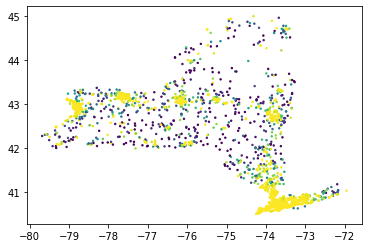

In [57]:
# Visualize the sampled points, colored by the probabilities given by the NL distribution
plt.scatter(pos_lons, pos_lats, c=probs_nl, s=2)

In [60]:
if sampling_method == 'population':
    raster_data = raster_pop
    raster_data_img = raster_pop_img
elif sampling_method == 'NL':
    raster_data = raster_nl
    raster_data_img = raster_nl_img

In [62]:
# Negative samples
_, pixels, _ = create_data(cut, all_pixels=False,
                           uniform=True,
                           N=total_sample_size,
                           binary_m=binary_m)


data_coordinate = pixel_to_coord(pixels[:, 0], pixels[:, 1], cutsizex[0], cutsizey[0], raster_data.transform)
neg_lons = data_coordinate[:, 0]
neg_lats = data_coordinate[:, 1]

print('Collecting object count...')
samples = np.stack([neg_lons, neg_lats], axis=1)

num_neighbor = 5000
object_count_array = kd_tree_object_count(satellite_size, samples, neg_lats, neg_lons, tree, center_x, center_y,
                                                      num_neighbor=num_neighbor)

probs_nl, _ = coord_to_pixel_loaded(neg_lons, neg_lats, raster_nl_img, raster_nl, shiftedx=0, shiftedy=0, plot=False)
probs_pop, _ = coord_to_pixel_loaded(neg_lons, neg_lats, raster_pop_img, raster_pop, shiftedx=0, shiftedy=0, plot=False)

# Save the negative training data
os.makedirs(f'../sample_data/{sampling_method}/', exist_ok=True)
file = f'../sample_data/{sampling_method}/sample_{total_sample_size}_{country}_{district}_False.pth'
torch.save([neg_lats, neg_lons, probs_nl, probs_pop, object_count_array], file)
del(object_count_array)

Querying tree...
Getting bounding boxes...
Creating masks
Masks created
Object count collected


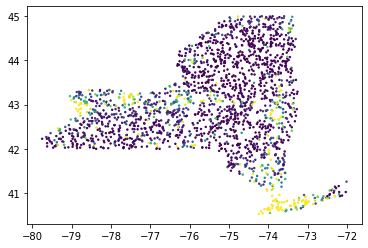

In [64]:
# Visualize the sampled points, colored by the probabilities given by the NL distribution
plt.scatter(neg_lons, neg_lats, c=probs_nl, s=2)

### Test data
Include all tiles in a target region and the proposal distribution. Do not contain the building count label.

In [65]:
cut = channel
_, pixels, _ = create_data(cut, all_pixels=True,
                           uniform=False,
                           N=20000,
                           binary_m=binary_m)
data_coordinate = pixel_to_coord(pixels[:, 0], pixels[:, 1], cutsizex[0], cutsizey[0], raster_data.transform)
lons = data_coordinate[:, 0]
lats = data_coordinate[:, 1]

probs_nl, _ = coord_to_pixel_loaded(lons, lats, raster_nl_img, raster_nl, shiftedx=0, shiftedy=0, plot=False)
probs_pop, _ = coord_to_pixel_loaded(lons, lats, raster_pop_img, raster_pop, shiftedx=0, shiftedy=0, plot=False)
            
print('Collecting pixel sizes...')
s_pix = compute_pixel_size(lats, lons, raster_data_img, raster_data)
print('Pixel sizes collected')

# Save the test data
os.makedirs(f'../sample_data/{sampling_method}/', exist_ok=True)
file = f'../sample_data/{sampling_method}/sample_{country}_{district}_All_area.pth'
torch.save([lats, lons, s_pix, probs_nl, probs_pop], file)

100%|██████████| 316419/316419 [02:19<00:00, 2274.80it/s]


Pixel sizes collected


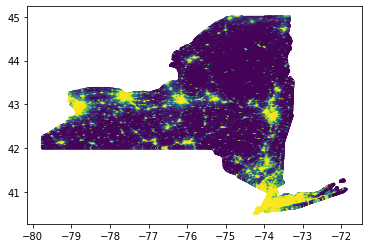

In [66]:
# Visualize all test points, colored by the probabilities given by the NL distribution
plt.scatter(lons, lats, c=probs_nl, s=2)